# Exploratory Data Analysis

## Generating master data
In this subsection I will depurate the database and form the "master data", a single .csv file containing all the relevant fields. This is very ineficient memory-wise, but eases plotting and selecting data drastically.

In [1]:
import pandas as pd

trips = pd.read_csv("datasets/Cab_Data.csv")
cities = pd.read_csv("datasets/City.csv")
customers = pd.read_csv("datasets/Customer_ID.csv")
transactions = pd.read_csv("datasets/Transaction_ID.csv")

master = pd.merge(pd.merge(trips, cities, on="City"),
                  pd.merge(customers, transactions, on="Customer ID"),
                  on="Transaction ID")

del trips, cities, customers, transactions
master

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,"814,885","24,701",29290,Male,28,10813,Card
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,"814,885","24,701",27703,Male,27,9237,Card
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,"814,885","24,701",28712,Male,53,11242,Cash
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,"814,885","24,701",28020,Male,23,23327,Cash
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,"814,885","24,701",27182,Male,33,8536,Card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,"418,859","127,001",52392,Male,24,15651,Cash
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,"418,859","127,001",53286,Male,32,6528,Cash
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,"418,859","127,001",52265,Male,56,7966,Cash
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,"418,859","127,001",52175,Male,32,6423,Card


## Assumptions:
- The field "Cost of Trip" includes every possible expense, in such a way that the profit of a trip can be defined as the difference between its "Price Charged" and "Cost of Trip".
- The field "Date of Travel", whose values are integers, represents days; two adjacent integers represent two adjacent days and the lowest integer in the record corresponds to the starting date indicated in the assignment (31/01/2016).

## Univariate Analysis
In this section we will make a shallow analysis of the individual variables, focusing on the "main" fields, i.e. those in ```Cab_Data.csv```.

As a start, let's see how many missing values are present:

In [2]:
row_count = master.shape[0]
def bold(msg: str) -> str:
    return f"\033[1m{msg}\033[0m"

print(f"{bold('Number of entries:')} {row_count}")
print()
print(bold('Percentage of available entries per field:'))
print((100 * master.count()) // row_count)
print()
print(bold('Data types of each field:'))
print(master.dtypes)

Number of entries: 359392

Percentage of available entries per field:
Transaction ID        100
Date of Travel        100
Company               100
City                  100
KM Travelled          100
Price Charged         100
Cost of Trip          100
Population            100
Users                 100
Customer ID           100
Gender                100
Age                   100
Income (USD/Month)    100
Payment_Mode          100
dtype: int64

Data types of each field:
Transaction ID          int64
Date of Travel          int64
Company                object
City                   object
KM Travelled          float64
Price Charged         float64
Cost of Trip          float64
Population             object
Users                  object
Customer ID             int64
Gender                 object
Age                     int64
Income (USD/Month)      int64
Payment_Mode           object
dtype: object


On a first look all entries are completelly filled. However, missing values might still be present in other poorly formated shapes (e.g. strings containing "NaN" literally).

The data types seem to be correct, although the format of the dates -increasing integers- is not intuitive and needs processing.

### Transaction ID:
There are no apparent missing values, so for now we just check the field's range and it's unique values.

In [3]:
ids = master["Transaction ID"]

print(f"\n{bold('Number of entries:')} {ids.count()}")
print(f"{bold('Unique values:')} {len(ids.unique())}")
print(f"{bold('Range of the IDs:')} [{ids.min()}-{ids.max()}]")
print(f"{bold('Size of the range:')} {ids.max()- ids.min()}")
print()
print(ids)


Number of entries: 359392
Unique values: 359392
Range of the IDs: [10000011-10440107]
Size of the range: 440096

0         10000011
1         10000012
2         10000013
3         10000014
4         10000015
            ...   
359387    10440101
359388    10440104
359389    10440105
359390    10440106
359391    10440107
Name: Transaction ID, Length: 359392, dtype: int64


There are as many unique values as entries, which means that each row is properly (uniquely) identified by its ID.

As an observation, it seems that each consecutive ID increments in 1. While the range suggests that there have been around 440000 entries, we only have access to around 360000. This could mean that the database has already been cleaned of missing entries or that only a selection of cities has been included, for example.

### Date of Travel
As I mentioned before, this field could be better formatted. In the assignment text it is mentioned that the database contains data from a period ranging from 31/01/2016 to 31/12/2018. If the integer at the ```Date of Travel``` field represents days, then there should be over 1000 of them (~3 years):

In [4]:
time = master["Date of Travel"]
time.max() - time.min()

1094

This seems to indicate that the dates are measured in days. With this information, we can transform the format of the dates into a more readable format:

In [5]:
origin = pd.to_datetime("31/01/2016")
master["Date of Travel"] = origin + pd.to_timedelta(time - time.min(), unit="D")
print(master["Date of Travel"])
print()
print(f"{bold('First day:')} {master['Date of Travel'].min()}")
print(f"{bold('Last day:')} {master['Date of Travel'].max()}")

0        2016-02-06
1        2016-02-04
2        2016-01-31
3        2016-02-05
4        2016-02-01
            ...    
359387   2018-02-06
359388   2018-02-02
359389   2018-02-03
359390   2018-02-03
359391   2018-01-31
Name: Date of Travel, Length: 359392, dtype: datetime64[ns]

First day: 2016-01-31 00:00:00
Last day: 2019-01-29 00:00:00


Note that last day is a month later than we were indicated (31/12/2018). This result still feels consistend as the second date is indeed 1094 days after the first.

A time variable is quite juicy. Let's see how the amount of entries varies per month (approx).

<AxesSubplot:>

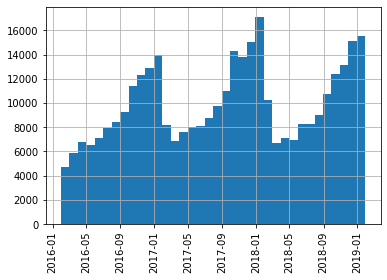

In [6]:
from matplotlib import pyplot as plt
plt.xticks(rotation='vertical')
master["Date of Travel"].hist(bins = 12 * 3)

A clear seasonality can be appreciated. This will contribute to an hypothesis later. For now, let's move on with the next field:

### Company
This is clearly a categorical field, so let's check which categories are present.

In [7]:
master["Company"].unique()

array(['Pink Cab', 'Yellow Cab'], dtype=object)

Two quick observations from this line:
- There are only two companies: "Pink Cab" and "Yellow Cab".
- There is no missing data, since we know that every entry is filled with either "Pink Cab" or "Yellow Cab" (i.e., there are no values with "missing", "error" or similar).

Lastly for this field let's check how do these two companies compare in amount of trips:

<AxesSubplot:>

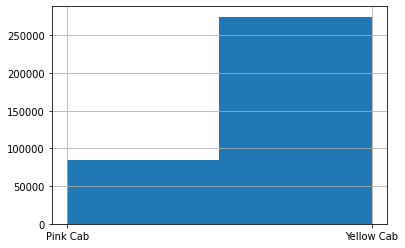

In [8]:
master["Company"].hist(bins=2)

For this time period, "Yellow Cab" has had around 3 times as many transactions as "Pink Cab". Take into account that that doesn't mean that they made 3 times as much money, for example, since other factors such as the margin or the distance of the trips might influence the profit.

This will form an hypothesis later: we need to thoroughly compare each company in other reasonable ways and speculate about which firm would be a better investment.

### City
Another categorical field. Let's see its possible values:

In [9]:
cities = master["City"]
cities.unique()

array(['ATLANTA GA', 'AUSTIN TX', 'BOSTON MA', 'CHICAGO IL', 'DALLAS TX',
       'DENVER CO', 'LOS ANGELES CA', 'MIAMI FL', 'NASHVILLE TN',
       'NEW YORK NY', 'ORANGE COUNTY', 'PHOENIX AZ', 'PITTSBURGH PA',
       'SACRAMENTO CA', 'SAN DIEGO CA', 'SEATTLE WA', 'SILICON VALLEY',
       'TUCSON AZ', 'WASHINGTON DC'], dtype=object)

Just like with companies, every entry seems to be a propper city. If one wanted to process this field they should be careful, though, since the formats vary: e.g. ```SILICON VALLEY``` has two words but no state or ```NEW YORK NY``` has three words (with state).
Let's see how many transactions there are per city:

<AxesSubplot:>

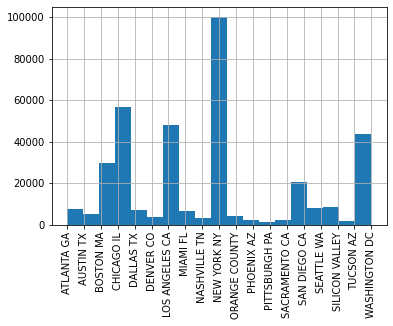

In [10]:
plt.xticks(rotation='vertical')
cities.hist(bins = len(cities.unique()))

The dominant cities/areas are New York, Chicago, LA and Washington. These are also the most populated cities in USA: the dataset is asking us to compare this transactions with the population of the cities. We will save this for the hypothesis.

### KM Travelled
This is a straightforward numerical value. Let's see what is its distribution: 

<AxesSubplot:>

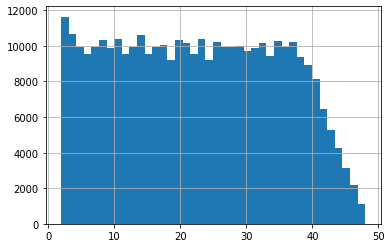

In [11]:
master["KM Travelled"].hist(bins=40)

A pretty uniform distribution, with a slight increase in trips less than 5km and a linear decay from 40 to 50 km. Apparently not a single transaction over 50km has been recorded in this database.

### Price Charged and Cost of Trip
These are twin values. Let's check their distribution:

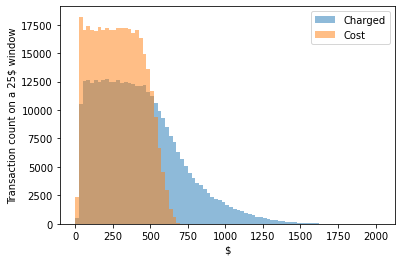

In [12]:
charged = master["Price Charged"]
cost = master["Cost of Trip"]
bins = list(range(0, int(charged.max()), 25))
plt.hist(charged, alpha = 0.5, bins=bins, label="Charged")
plt.hist(cost, alpha = 0.5, bins=bins, label="Cost")
plt.xlabel("$")
plt.ylabel("Transaction count on a 25$ window")
plt.legend()

The charged prices has a higher distribution of values than the cost prices, as expected. Notice, though, that one distribution is not just a translated version of the other. This indicates that the profit margin is variable with the cost.

Talking about margin, that is an interesting field to consider. Let's include it in the database and see how it relates, for example, to the traveled km:

In [13]:
master["Profit"] = charged - cost
lowest = int(master["Profit"].min())
highest = int(master["Profit"].max())
print(f'Range of the margin: [{lowest}$ to {highest}$]')

Range of the margin: [-220$ to 1463$]


That's unexpected! it seems that for some trips there have been losses (negative profit). Let's see what kind of distribution the profit has:

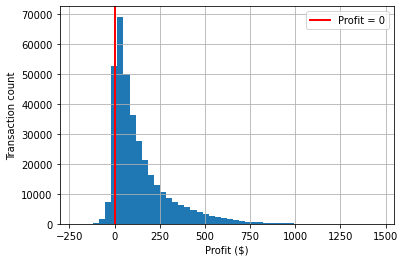

In [15]:
master["Profit"].hist(bins=50)
plt.axvline(0, color="red", linewidth=2,label="Profit = 0")
plt.ylabel("Transaction count")
plt.xlabel("Profit ($)")
plt.legend()

As we can see, most of the points have a positive profit, but there is still a lot of points where are losses. Finally, let's check what's the proportion between this points.

In [17]:
total_transactions = master["Profit"].count()
losses_transactions = master["Profit"].loc[master["Profit"] < 0].count()
f"Percentage of trips with losses: {(100 * losses_transactions) // total_transactions}%"

'Percentage of trips with losses: 6%'

In [18]:
# Saving the master data
master.to_csv("datasets/master_data.csv")

# Hypothesis
1. Seasonality is present in the the average trip's profit.
2. Seasonality is present in the length of the trips.
3. One of the two companies is growing faster than the other.
4. One of the two companies has more profit per trip than the other.
5. Some of the cities have more transactions than the average even after taking its population into account.
6. Some of the cities have, in average, more long trips than others.

## Seasonality is present in the the average trip's profit.
To test this out, I will average profit by day and see how it evolves.

Text(0, 0.5, 'Mean profit($)')

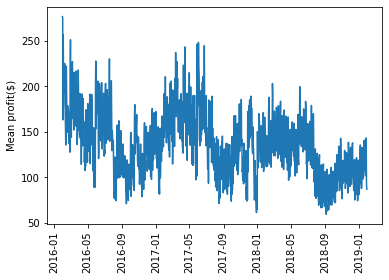

In [42]:
profit_time_series = master[["Profit"]].set_index(master["Date of Travel"])
daily_mean = profit_time_series.groupby(pd.Grouper(freq="D")).mean()
plt.plot(daily_mean.index, daily_mean["Profit"])
plt.xticks(rotation='vertical')
plt.ylabel("Mean profit ($)")

Too grainy. Let's try again grouping by month instead. Let's also plot how many transactions were there in each month, see if there is some correlation:

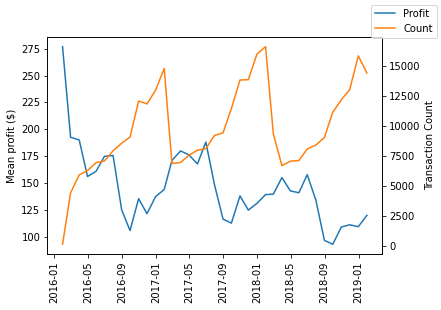

In [58]:
monthly_mean = profit_time_series.groupby(pd.Grouper(freq="M")).mean()
monthly_count = profit_time_series.groupby(pd.Grouper(freq="M")).count()

fig, ax1 = plt.subplots()

ax1.set_ylabel('Mean profit ($)',)
ax1.plot(monthly_mean.index, monthly_mean["Profit"], label="Profit", color="C0")
ax1.tick_params(axis="x", rotation=90)

ax2 = ax1.twinx()

ax2.set_ylabel('Transaction Count')
ax2.plot(monthly_count.index, monthly_count["Profit"], label="Count", color="C1")

fig.legend()

Side by side with the amount of transactions, it seems like the **Law of Demand** is at work here. There is indeed a seasonality: when the demand starts increasing -i.e., transactions start raising around August-, the "value" of the cab trips starts decreasing.

## Seasonality is present in the length of the trips.
Another way to ask this is: is there a shift between inter and intra city trips between seasons? Again, let's do a monthly average and check it out.

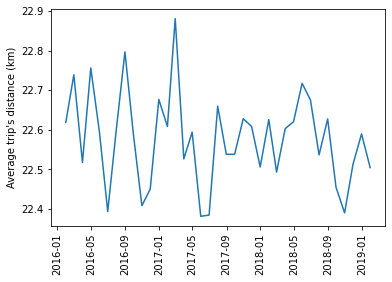

In [80]:
kms = master[["KM Travelled"]].set_index(master["Date of Travel"])
daily_mean_kms = kms.groupby(pd.Grouper(freq="M")).mean()

plt.plot(daily_mean_kms.index, daily_mean_kms["KM Travelled"])
plt.xticks(rotation='vertical')
plt.ylabel("Average trip's distance (km)")
plt.show()

If there is seasonality here, its effect would be less than half a kilometer in the average. To gain perspective, let's just replot this in a 5 km interval:

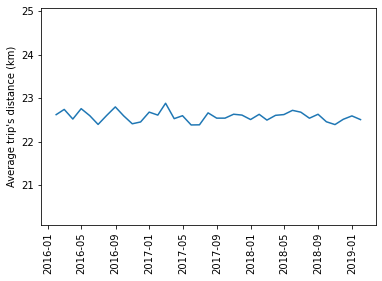

In [84]:
plt.plot(daily_mean_kms.index, daily_mean_kms["KM Travelled"])
plt.xticks(rotation='vertical')
plt.ylabel("Average trip's distance (km)")
center = daily_mean_kms["KM Travelled"].mean()
plt.ylim(center-2.5, center+2.5)
plt.show()

The average trip's distance seems to be pretty flat overall; for further analysis we could just consider